Copyright © 2023 ETH Zurich
All rights reserved.

This software may be modified and distributed under the terms
of the GPL-3.0 license.  See the LICENSE file for details.

Author: Carl Friess

In [1]:
import math
import os.path

import matplotlib.pyplot as plt
import numpy as np

from geometry import Environment, Line
from homogeneous import v2t, h2points, points2h
from icp import PointCloud, ICP
from log import load_poses_cf, load_poses_vicon, load_scans, extract_points

plt.rcParams.update({'font.size': 18})

In [2]:
def evaluate_icp(path, ref, cur, tx, ty, theta):
    data_cf = load_poses_cf(os.path.join(path, "poses.csv"))
    data_vicon = load_poses_vicon(os.path.join(path, "vicon_poses.csv"))
    scans = load_scans(os.path.join(path, "scans.csv"))

    # Calculate ground truth transform
    T_g = v2t((-data_cf[cur][0][0], -data_cf[cur][0][1], 0))
    T_g = v2t((0, 0, -data_cf[cur][0][2])) @ T_g
    T_g = v2t((0, 0, data_vicon[cur][2])) @ T_g
    T_g = v2t((data_vicon[cur][0], data_vicon[cur][1], 0)) @ T_g

    T_g = v2t((-data_vicon[ref][0], -data_vicon[ref][1], 0)) @ T_g
    T_g = v2t((0, 0, -data_vicon[ref][2])) @ T_g
    T_g = v2t((0, 0, data_cf[ref][0][2])) @ T_g
    T_g = v2t((data_cf[ref][0][0], data_cf[ref][0][1], 0)) @ T_g

    # Assemble result transform
    T_r = v2t((tx, ty, theta))

    env = Environment([])
    ax = env.plot(size=(10, 10))
    cloud1 = extract_points(scans[ref], data_cf[ref][0][0], data_cf[ref][0][1], data_cf[ref][0][2])
    cloud1.plot(ax, color="#ff7f0e")
    cloud2 = extract_points(scans[cur], data_cf[cur][0][0], data_cf[cur][0][1], data_cf[cur][0][2])
    cloud2.plot(ax, color="#1f77b4")
    # cloud3 = ICP.to_point_cloud(h2points(T_g.dot(points2h(ICP.from_point_cloud(cloud2)))))
    # cloud3.plot(ax, color="yellow")
    cloud4 = ICP.to_point_cloud(h2points(T_r.dot(points2h(ICP.from_point_cloud(cloud2)))))
    cloud4.plot(ax, color="#2ca02c")
    # plt.savefig(f"icp-{ref.replace('/', '-')}-{cur.replace('/', '-')}.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

    dT = T_r @ np.linalg.inv(T_g)
    e_t, e_r = np.linalg.norm(dT[0:2, 2]), math.acos(dT[0, 0])

    print("Translation error =", round(e_t * 100, 1), "cm")
    print("Rotation error =", round(e_r / math.pi * 180, 2), "deg")

In [3]:
def evaluate(env, path, num_drones, max_measurement=math.inf):
    data_cf = load_poses_cf(os.path.join(path, "poses.csv"))
    data_vicon = load_poses_vicon(os.path.join(path, "vicon_poses.csv"))
    scans = load_scans(os.path.join(path, "scans.csv"))

    poses_unopt = []
    poses_opt = []
    poses_vicon = []
    for i in range(num_drones):
        poses_unopt.append([data_cf[p][0] for p in filter(lambda k: k.startswith(f"{i}/"), data_cf.keys())])
        poses_opt.append([data_cf[p][-1] for p in filter(lambda k: k.startswith(f"{i}/"), data_cf.keys())])
        poses_vicon.append([data_vicon[p] for p in filter(lambda k: k.startswith(f"{i}/"), data_vicon.keys())])

    # Plot SLAM poses
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot()
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.axis('equal')
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"]
    for i in range(num_drones):
        ax.plot([t[0] for t in poses_unopt[i]], [t[1] for t in poses_unopt[i]], marker="x", color=colors[i],
                label=f"Drone {i}")
        ax.plot([t[0] for t in poses_opt[i]], [t[1] for t in poses_opt[i]], marker="8", color=colors[i],
                linestyle="dotted", label=f"Drone {i} (opt)")
        ax.plot([t[0] for t in poses_vicon[i]], [t[1] for t in poses_vicon[i]], marker="s", color=colors[i],
                linestyle="dashed",
                label=f"Drone {i} (vicon)")
    ncols = num_drones if num_drones > 1 else 3
    width = ncols * 0.23
    plt.legend(bbox_to_anchor=((1 - width) / 2, 1.02, width, 0.2), loc="lower left", mode="expand", borderaxespad=0,
               ncol=ncols)
    # plt.savefig(os.path.join(path, "poses.pdf").replace("data/", "").replace("/", "-"),
    #             bbox_inches="tight")
    plt.show()
    plt.close()

    # Plot scans (before SLAM)
    ax = env.plot(size=(8, 8), color="#1f77b4")
    cloud_before = PointCloud([])
    for p in scans.keys():
        pose = data_cf[p][0]
        cloud_before += extract_points(scans[p], pose[0], pose[1], pose[2], max_measurement=max_measurement)
    cloud_before.plot(ax, color="#2ca02c", markersize=2)
    env.plot(ax=ax, color="#1f77b4")
    # plt.savefig(os.path.join(path, "before.pdf").replace("data/", "").replace("/", "-"),
    #             bbox_inches="tight")
    plt.show()
    plt.close()

    # Plot scans (after SLAM)
    ax = env.plot(size=(8, 8), color="#1f77b4")
    cloud_after = PointCloud([])
    for p in scans.keys():
        pose = data_cf[p][-1]
        cloud_after += extract_points(scans[p], pose[0], pose[1], pose[2], max_measurement=max_measurement)
    cloud_after.plot(ax, color="#2ca02c", markersize=2)
    env.plot(ax=ax, color="#1f77b4")
    # plt.savefig(os.path.join(path, "after.pdf").replace("data/", "").replace("/", "-"),
    #             bbox_inches="tight")
    plt.show()
    plt.close()

    # Calculate pose RMSE
    get_error = lambda p: np.linalg.norm([p[1][0] - p[0][0], p[1][1] - p[0][1]])
    errors_unopt = np.array(list(map(get_error, ((data_cf[p][0], data_vicon[p]) for p in data_cf.keys()))))
    errors_opt = np.array(list(map(get_error, ((data_cf[p][-1], data_vicon[p]) for p in data_cf.keys()))))
    rmse_unopt = np.sqrt(np.mean(errors_unopt ** 2))
    rmse_opt = np.sqrt(np.mean(errors_opt ** 2))
    print(f"Pose RMSE Unoptimized = {rmse_unopt}")
    print(f"Pose RMSE Optimized = {rmse_opt}")

    # Calculate map RMSE
    get_dists = lambda points: np.array(list(map(lambda p: min(map(lambda l: l.dist(p), env.lines)), points)))
    map_rmse_unopt = np.sqrt(np.mean(get_dists(cloud_before.points) ** 2))
    map_rmse_opt = np.sqrt(np.mean(get_dists(cloud_after.points) ** 2))
    print(f"Map RMSE Unoptimized = {map_rmse_unopt}")
    print(f"Map RMSE Optimized = {map_rmse_opt}")

# Experiment 1

In [4]:
env1a = Environment([
    Line(-1.5, 2.5, 2.5, 2.5),
    Line(2.5, 2.5, 2.5, -2.5),
    Line(-1.5, -2.5, 2.5, -2.5),
    Line(-1.5, 2.5, -1.5, -2.5),
    Line(-0.5, 0.5, 0.5, 0.5),
    Line(-0.5, 1.5, 0.5, 1.5),
    Line(-0.5, 0.5, -0.5, 1.5),
    Line(0.5, 0.5, 0.5, 1.5),
    Line(-0.5, -0.5, 0.5, -0.5),
    Line(-0.5, -1.5, 0.5, -1.5),
    Line(-0.5, -0.5, -0.5, -1.5),
    Line(0.5, -0.5, 0.5, -1.5),
    Line(1.5, 1.5, 1.5, -1.5),
])
env1b = Environment([
    Line(-1.5, 2.5, 2.5, 2.5),
    Line(2.5, 2.5, 2.5, 0.5),
    Line(2.5, 0.5, 3.02, 0.5),
    Line(3.02, 0.5, 3.02, -0.5),
    Line(3.02, -0.5, 2.5, -0.5),
    Line(2.5, -0.5, 2.5, -2.5),
    Line(-1.5, -2.5, 2.5, -2.5),
    Line(-1.5, 2.5, -1.5, -2.5),
    Line(-0.5, 0.5, 0.5, 0.5),
    Line(-0.5, 1.5, 0.5, 1.5),
    Line(-0.5, 0.5, -0.5, 1.5),
    Line(0.5, 0.5, 0.5, 1.5),
    Line(-0.5, -0.5, 0.5, -0.5),
    Line(-0.5, -1.5, 0.5, -1.5),
    Line(-0.5, -0.5, -0.5, -1.5),
    Line(0.5, -0.5, 0.5, -1.5),
    Line(1.5, 1.5, 1.5, -1.5),
])

### ICP Evaluation

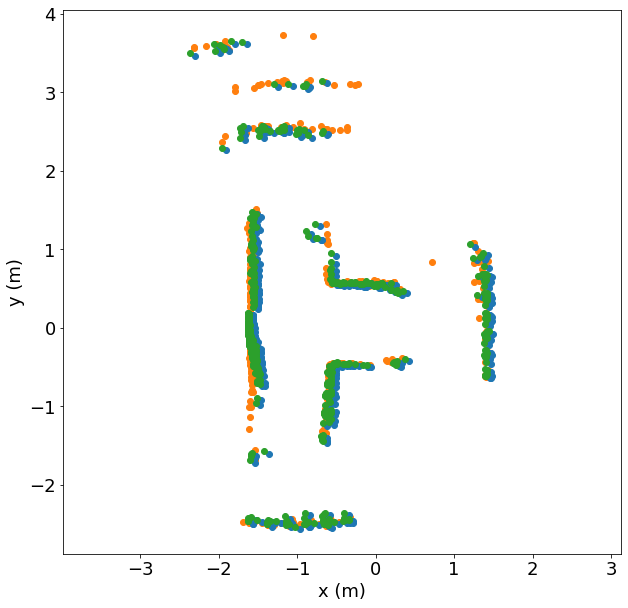

Translation error = 0.5 cm
Rotation error = 0.63 deg


In [5]:
evaluate_icp("data/icp/", "0/0", "1/0", -0.06, 0.03, -0.0)

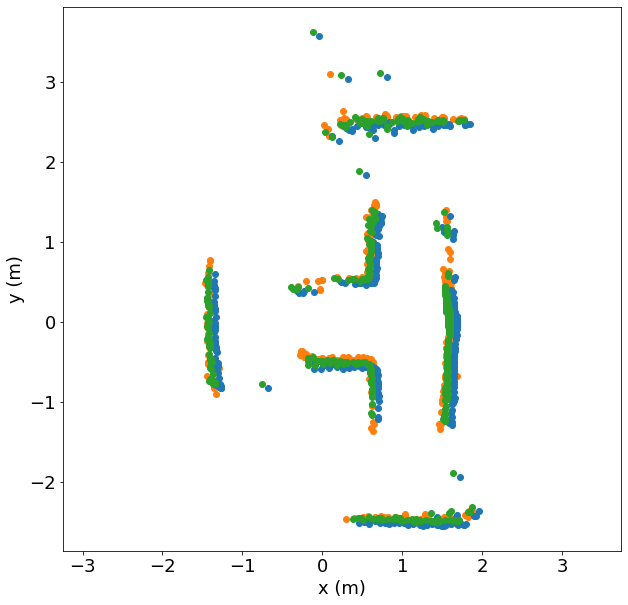

Translation error = 5.7 cm
Rotation error = 0.61 deg


In [6]:
evaluate_icp("data/icp/", "0/2", "1/2", -0.08, 0.05, 0.0)

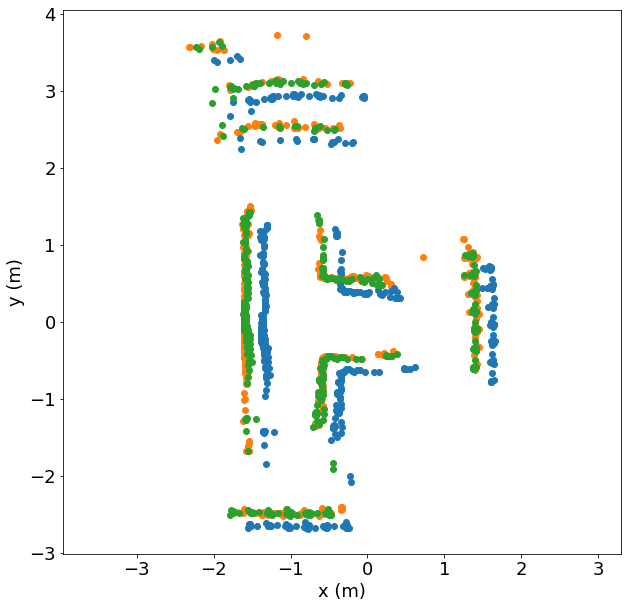

Translation error = 1.6 cm
Rotation error = 0.0 deg


In [7]:
evaluate_icp("data/icp/", "0/0", "0/8", -0.23, 0.17, -0.0)

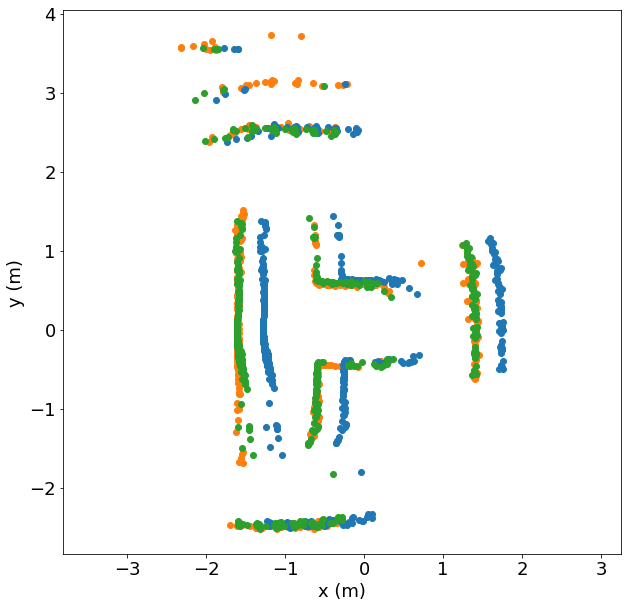

Translation error = 0.7 cm
Rotation error = 0.98 deg


In [8]:
evaluate_icp("data/icp/", "0/0", "1/8", -0.33, -0.03, -0.02)

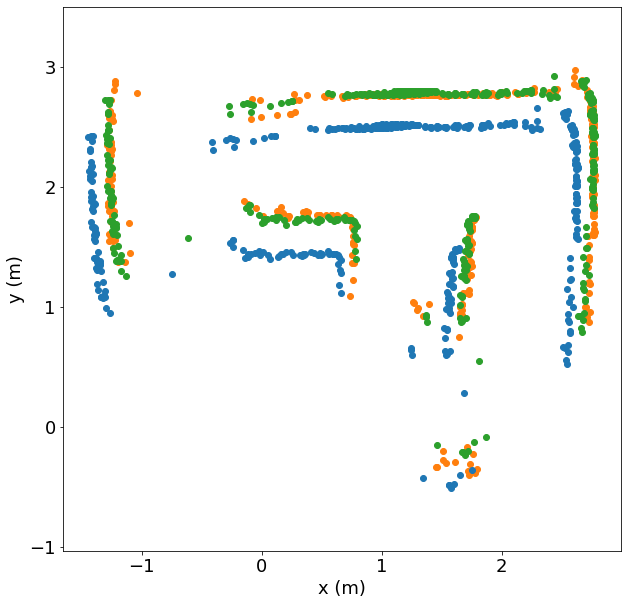

Translation error = 3.2 cm
Rotation error = 0.56 deg


In [9]:
evaluate_icp("data/icp/", "0/12", "1/4", 0.12, 0.29, -0.01)

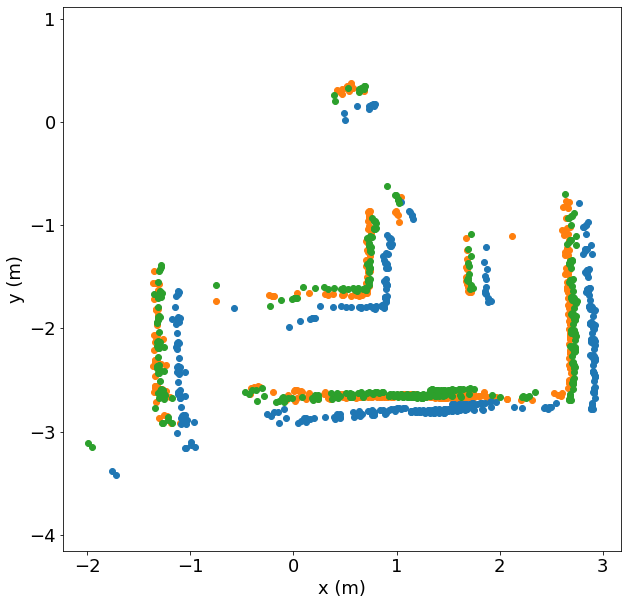

Translation error = 6.1 cm
Rotation error = 0.2 deg


In [10]:
evaluate_icp("data/icp/", "0/4", "1/12", -0.10, 0.20, -0.04)

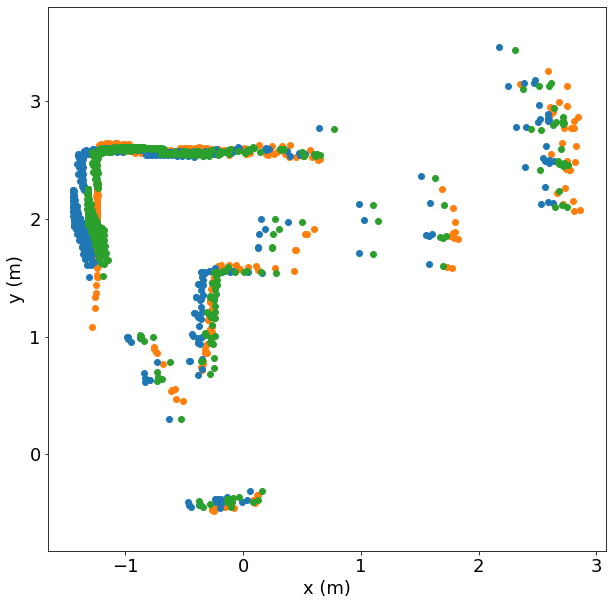

Translation error = 3.5 cm
Rotation error = 1.32 deg


In [11]:
evaluate_icp("data/icp/", "0/10", "1/6", 0.10, -0.0, -0.01)

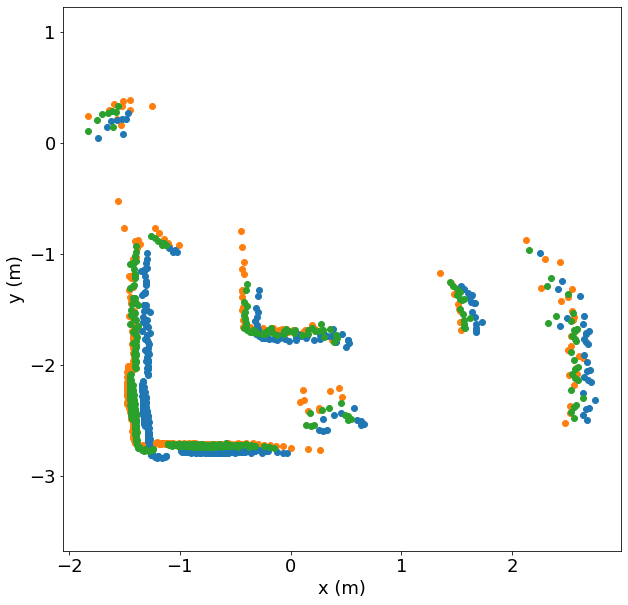

Translation error = 4.2 cm
Rotation error = 0.04 deg


In [12]:
evaluate_icp("data/icp/", "0/6", "1/10", -0.09, 0.05, -0.01)

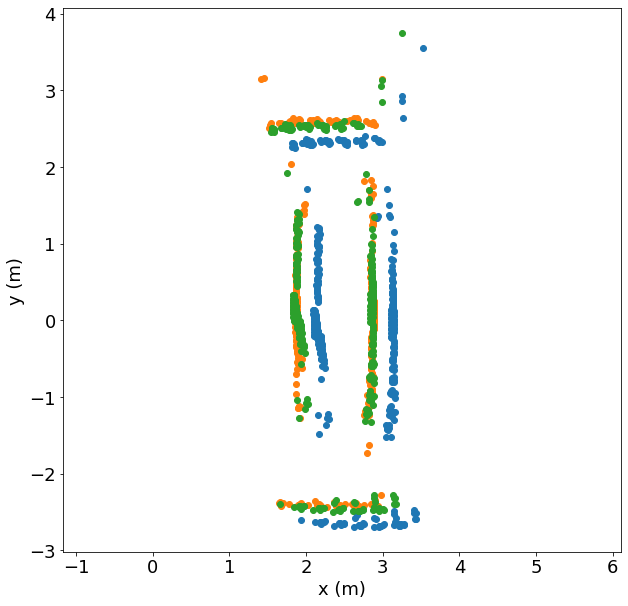

Translation error = 11.8 cm
Rotation error = 1.16 deg


In [13]:
evaluate_icp("data/icp/", "0/15", "1/15", -0.27, 0.2, 0.0)

### Two Drones

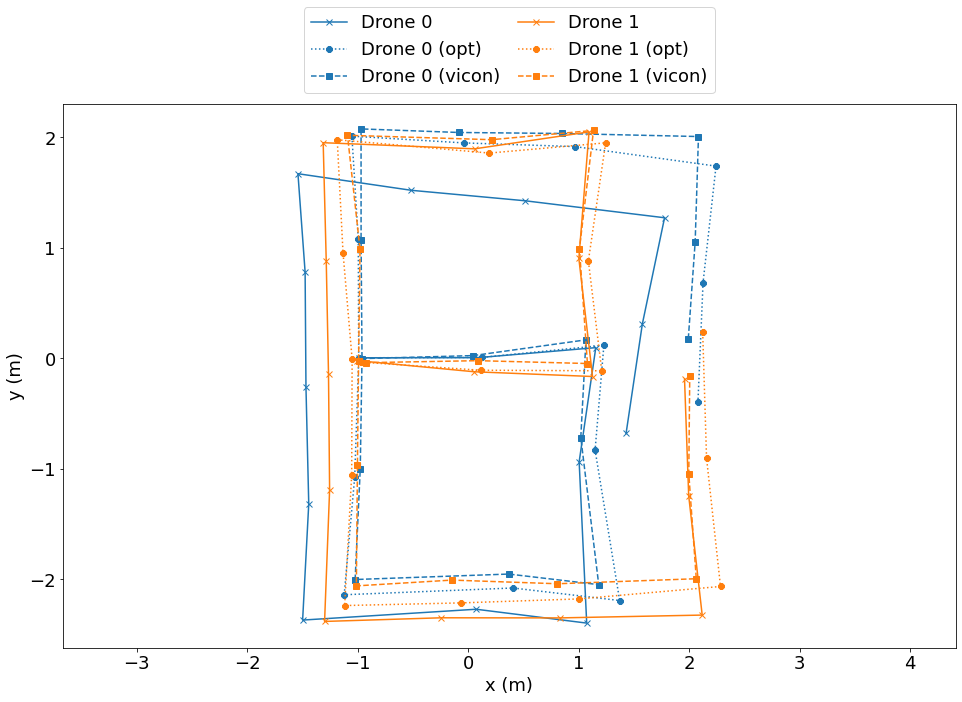

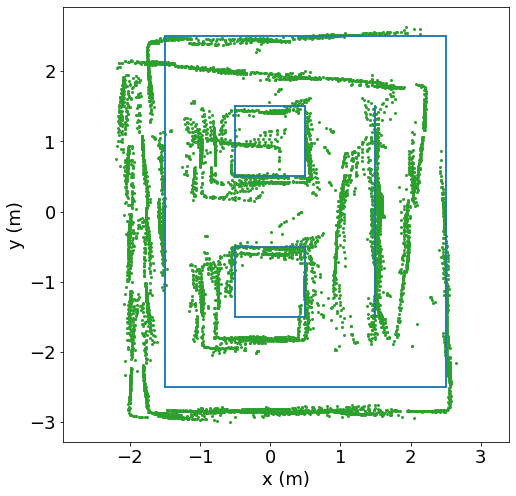

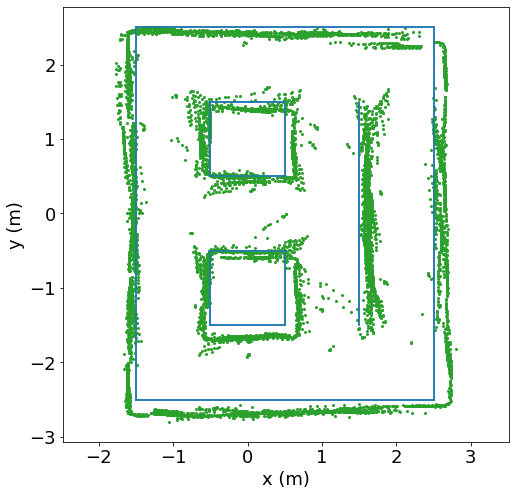

Pose RMSE Unoptimized = 0.45501210949425575
Pose RMSE Optimized = 0.2058410610999503
Map RMSE Unoptimized = 0.30902085294952414
Map RMSE Optimized = 0.13116427955545332


In [14]:
evaluate(env1a, "data/exp1/two-drones/", num_drones=2, max_measurement=1.2)

### Four Drones

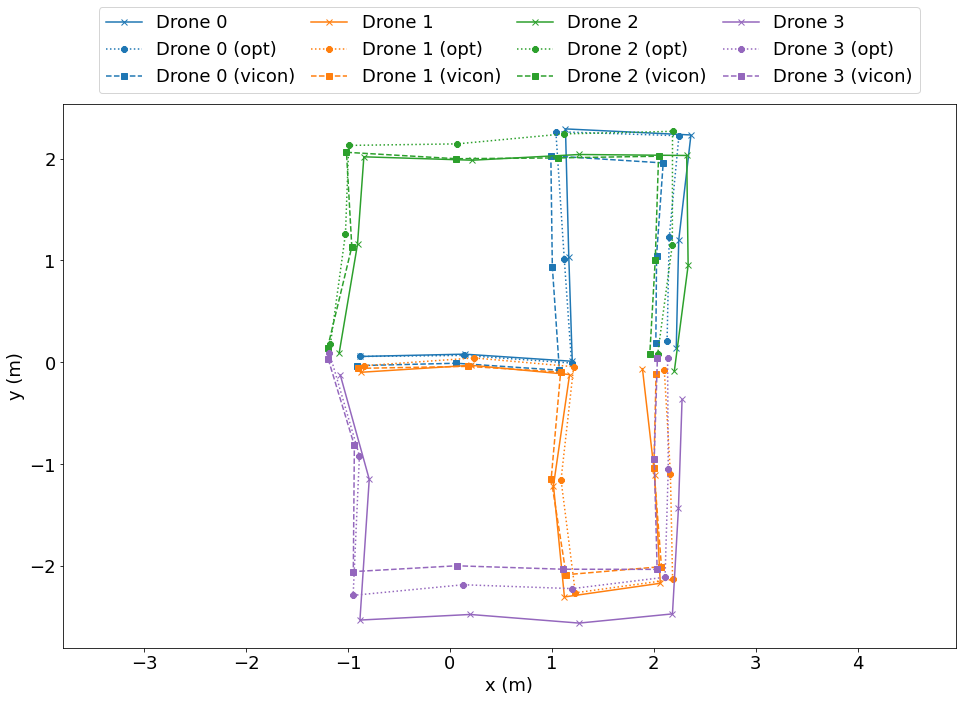

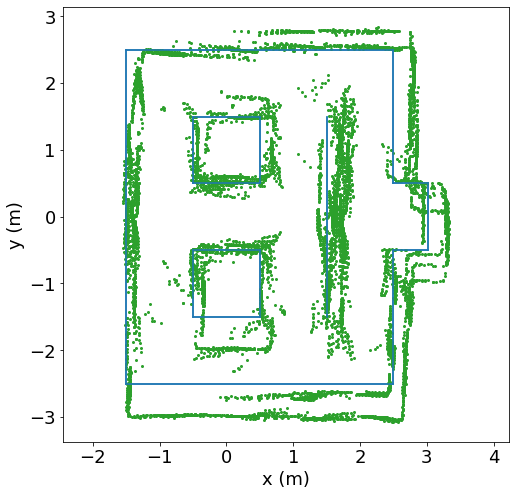

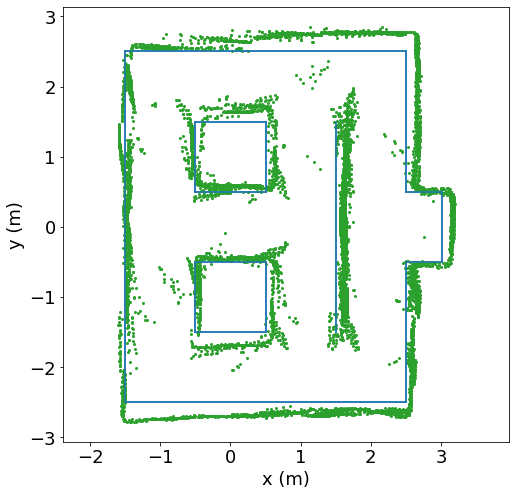

Pose RMSE Unoptimized = 0.28593760505276244
Pose RMSE Optimized = 0.16464651148649448
Map RMSE Unoptimized = 0.225116645069478
Map RMSE Optimized = 0.14493852008060001


In [15]:
evaluate(env1b, "data/exp1/four-drones/", num_drones=4, max_measurement=1.2)

# Experiment 2

In [16]:
env2 = Environment([
    Line(-2.5, 2.5, 2.5, 2.5),
    Line(-2.5, -1.5, 2.5, -1.5),
    Line(-2.5, -1.5, -2.5, 2.5),
    Line(2.5, -1.5, 2.5, 2.5),
    Line(-0.5, 1.5, 1.5, 1.5),
    Line(1.5, 1.5, 1.5, 0.5),
    Line(0.5, 0.5, 1.5, 0.5),
    Line(0.5, -0.5, 1.5, -0.5),
    Line(-1.5, -0.5, -0.5, -0.5),
    Line(-0.5, -0.5, -0.5, 0.5),
    Line(-1.5, 0.5, -0.5, 0.5),
    Line(-1.5, 0.5, -1.5, 1.5),
])

## Two Drones

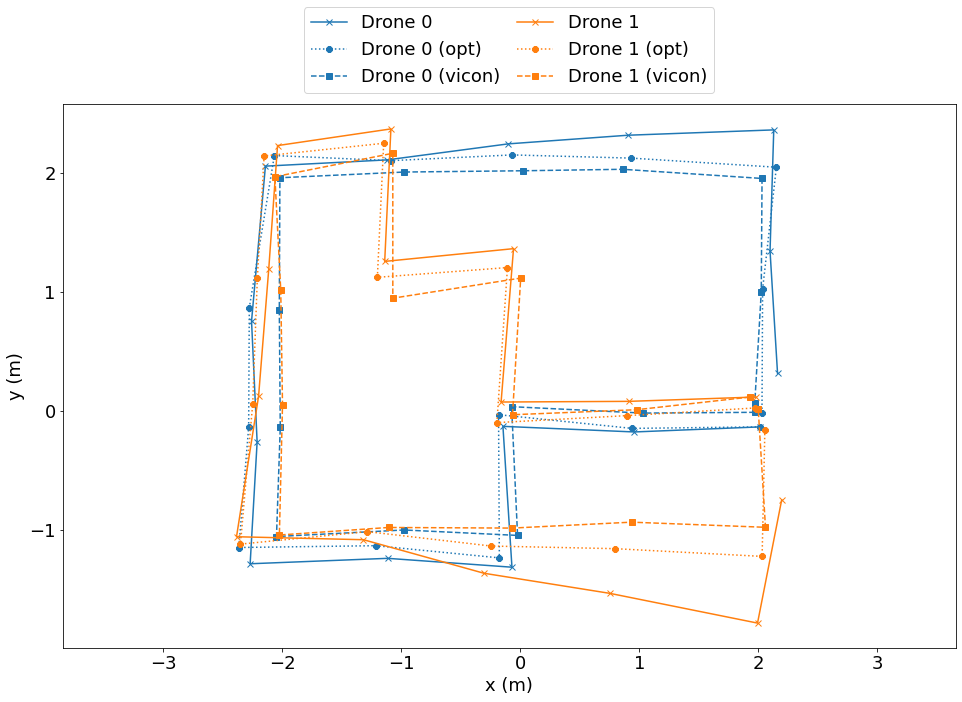

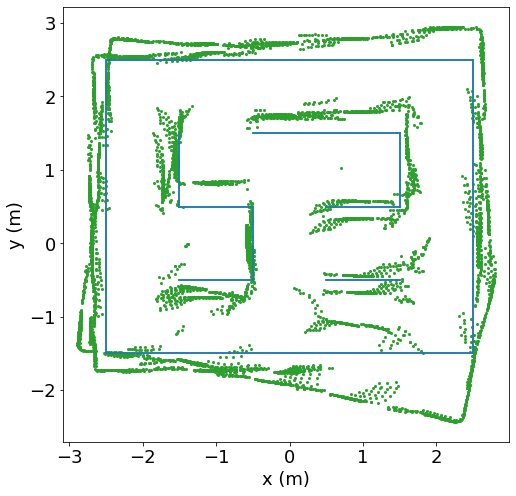

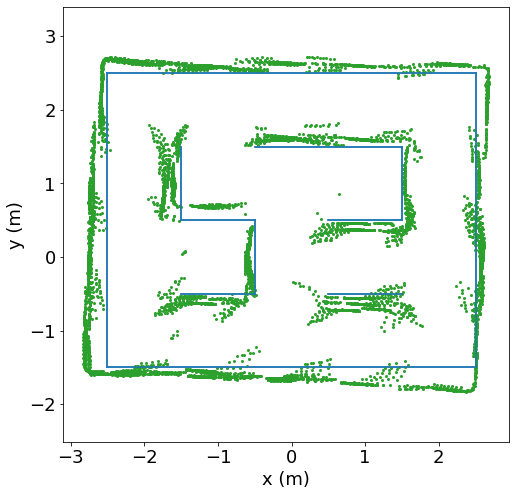

Pose RMSE Unoptimized = 0.34153076949558775
Pose RMSE Optimized = 0.20065347695237393
Map RMSE Unoptimized = 0.2525659269072626
Map RMSE Optimized = 0.1594748198475427


In [17]:
evaluate(env2, "data/exp2/two-drones/", num_drones=2, max_measurement=0.8)

## Four Drones

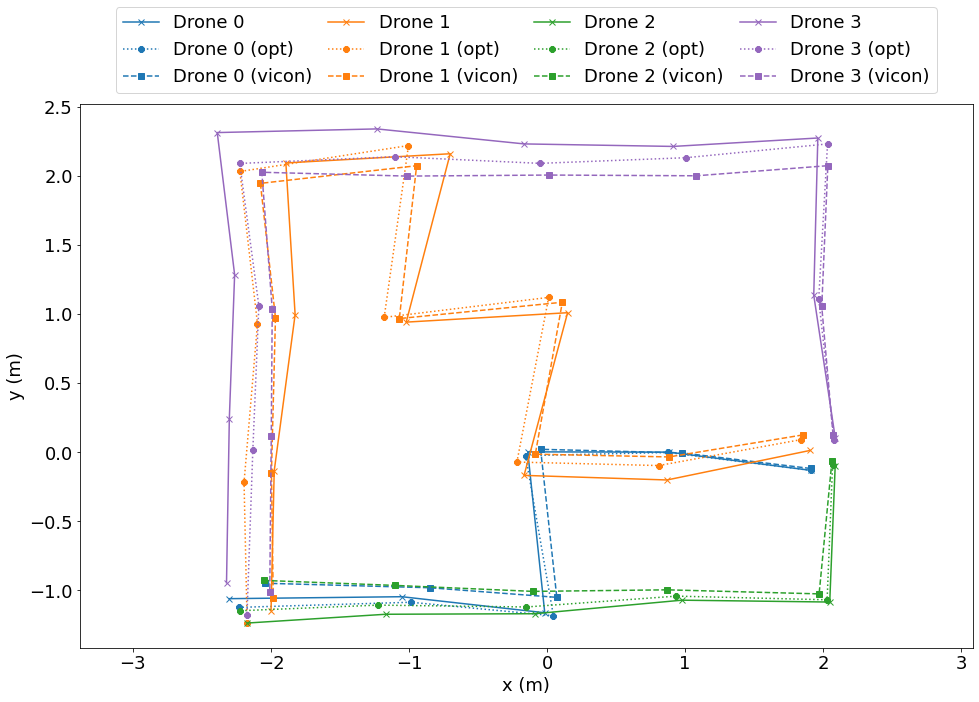

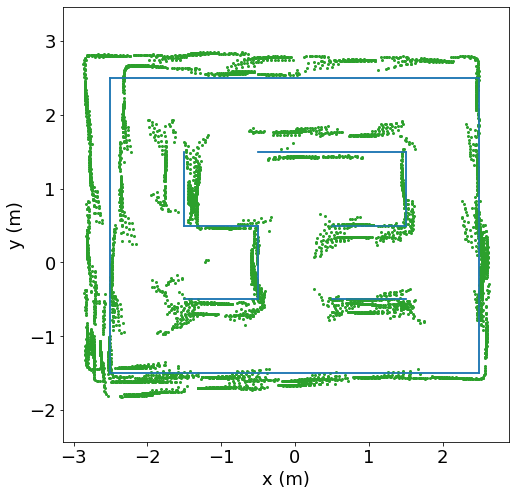

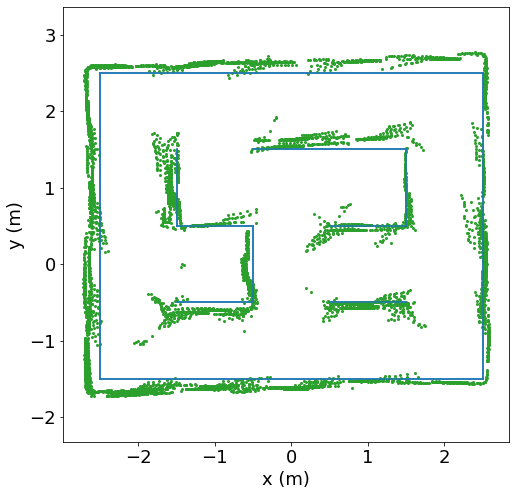

Pose RMSE Unoptimized = 0.21824128851134408
Pose RMSE Optimized = 0.15148008448759304
Map RMSE Unoptimized = 0.178976792044264
Map RMSE Optimized = 0.12670518966341934


In [18]:
evaluate(env2, "data/exp2/four-drones/", num_drones=4, max_measurement=0.8)

# Experiment 3

In [19]:
env3 = Environment([
    Line(0.5, 0.5, 0.5, 1.5),
    Line(0.5, 1.5, 1.5, 1.5),
    Line(1.5, 1.5, 1.5, 0.5),
    Line(1.5, 0.5, 0.5, 0.5),
    Line(-0.5, -0.5, -0.5, -1.5),
    Line(-0.5, -1.5, -1.5, -1.5),
    Line(-1.5, -1.5, -1.5, -0.5),
    Line(-1.5, -0.5, -0.5, -0.5),
    Line(-0.5, 0.5, -0.5, 2.5),
    Line(-0.5, 2.5, 2.5, 2.5),
    Line(2.5, 2.5, 2.5, -0.5),
    Line(2.5, -0.5, 0.5, -0.5),
    Line(0.5, -0.5, 0.5, -2.5),
    Line(0.5, -2.5, -2.5, -2.5),
    Line(-2.5, -2.5, -2.5, 0.5),
    Line(-2.5, 0.5, -0.5, 0.5),
])

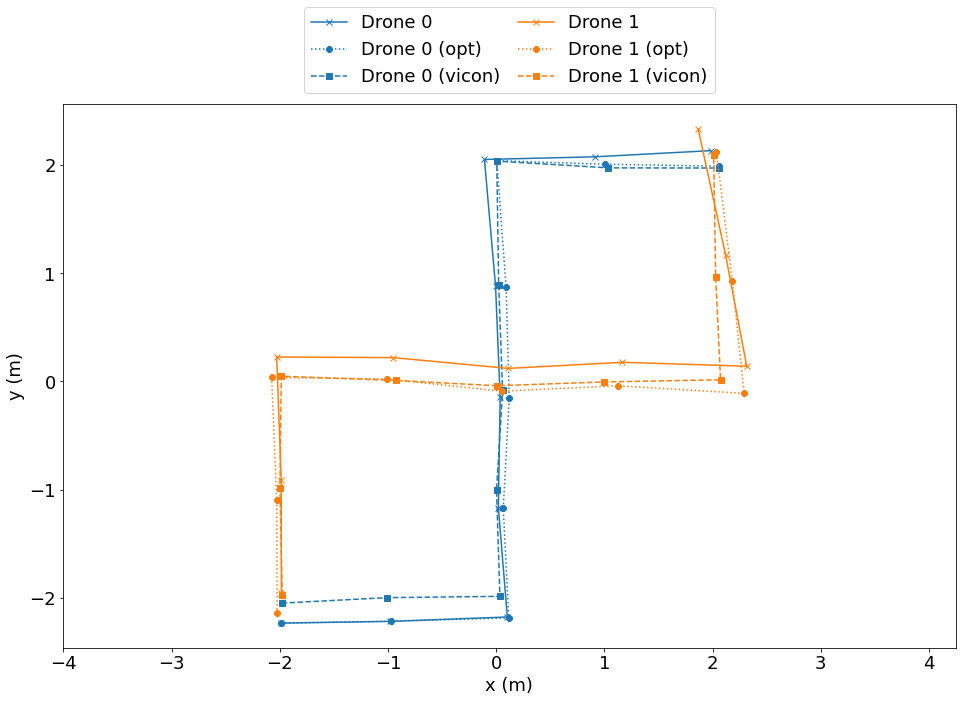

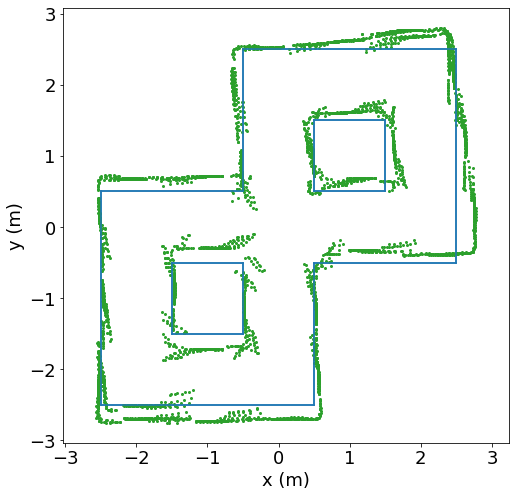

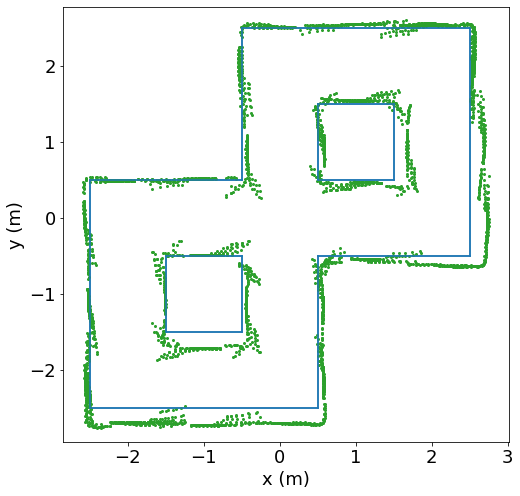

Pose RMSE Unoptimized = 0.18496007709317933
Pose RMSE Optimized = 0.13875550311293142
Map RMSE Unoptimized = 0.14441514414634177
Map RMSE Optimized = 0.11595948403722352


In [20]:
evaluate(env3, "data/exp3/two-drones/", num_drones=2, max_measurement=0.8)

# Experiment 4

In [21]:
env4 = Environment([
    Line(0.5, 0.5, 0.5, -0.5),
    Line(0.5, -0.5, -0.5, -0.5),
    Line(-0.5, -0.5, -0.5, 0.5),
    Line(-0.5, 0.5, 0.5, 0.5),
    Line(1.5, 1.5, 1.5, -1.5),
    Line(1.5, -1.5, -1.5, -1.5),
    Line(-1.5, -1.5, -1.5, 1.5),
    Line(-1.5, 1.5, 1.5, 1.5),
])

## 0.2 m/s

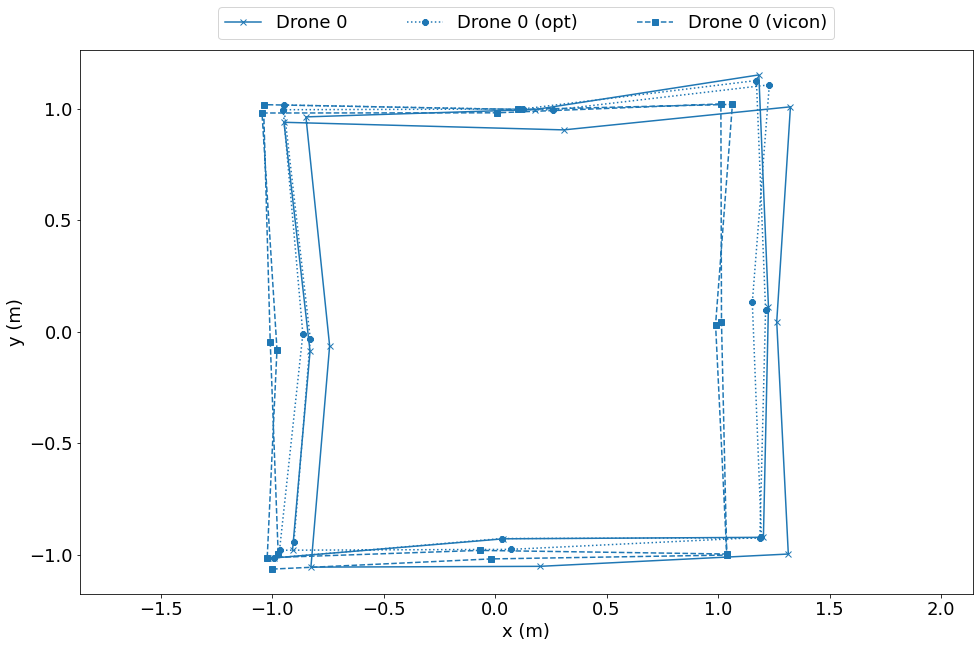

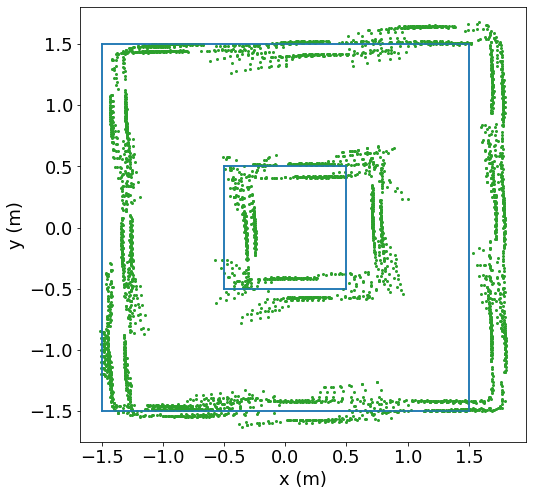

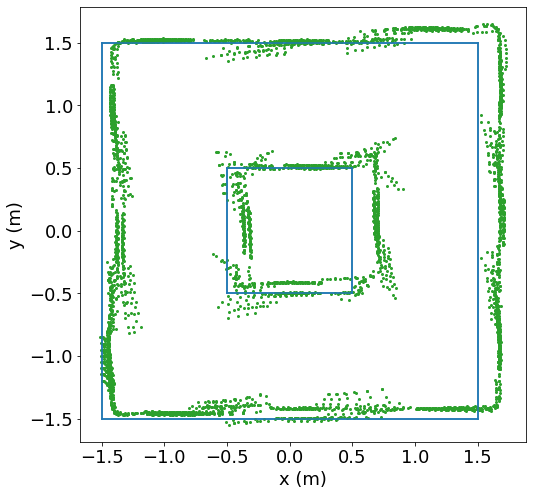

Pose RMSE Unoptimized = 0.20416175869826417
Pose RMSE Optimized = 0.14544998662353473
Map RMSE Unoptimized = 0.16006594496560106
Map RMSE Optimized = 0.1189786923755334


In [22]:
evaluate(env4, "data/exp4/0_2/", num_drones=1, max_measurement=0.8)

## 0.8 m/s

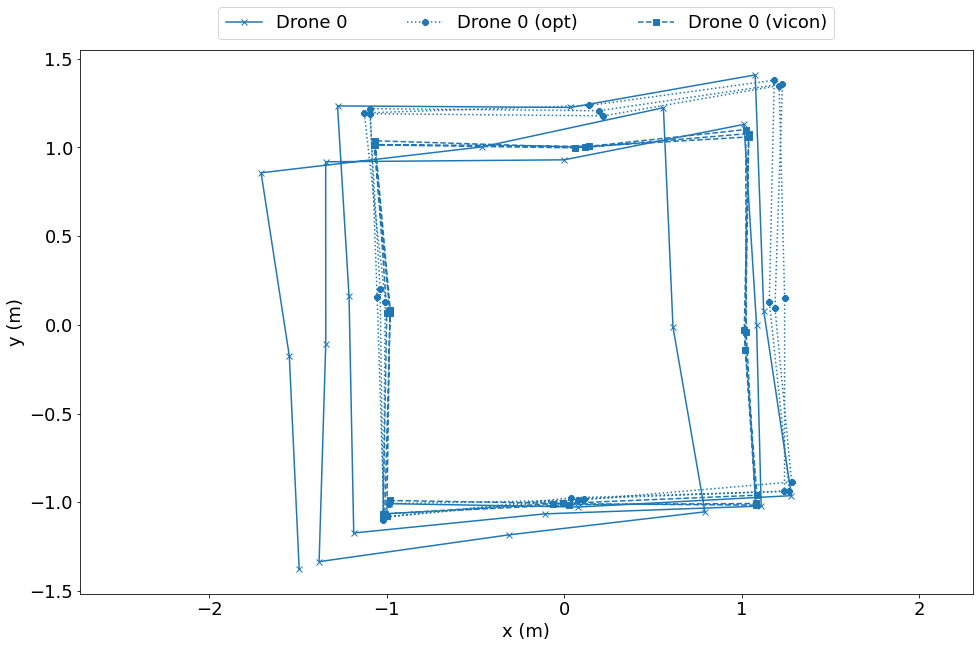

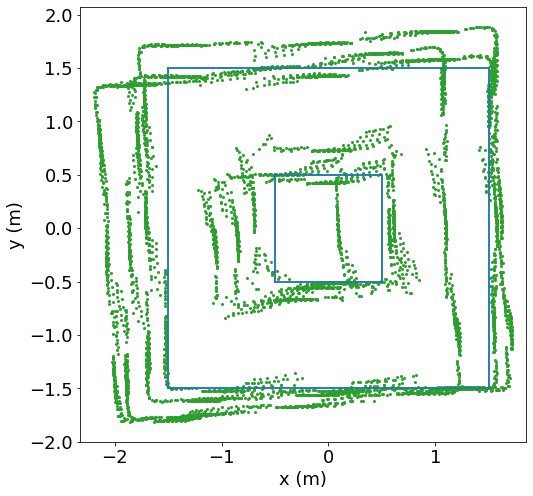

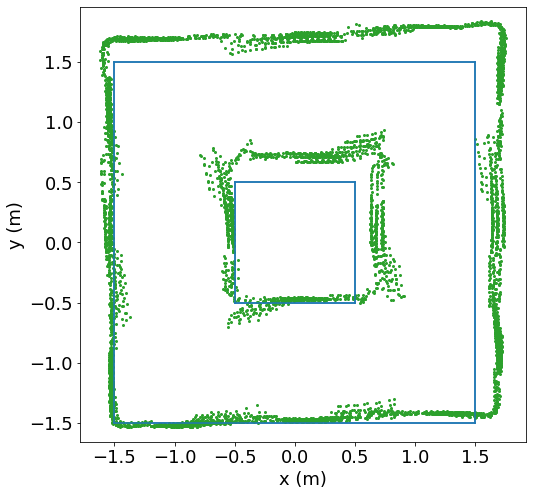

Pose RMSE Unoptimized = 0.34633659410321477
Pose RMSE Optimized = 0.19756635141269255
Map RMSE Unoptimized = 0.2508531429511137
Map RMSE Optimized = 0.15996181235049095


In [23]:
evaluate(env4, "data/exp4/0_8/", num_drones=1, max_measurement=0.8)